In [1]:
import pandas as pd
import sqlite3
from sqlite3 import Error
from datetime import datetime
%matplotlib inline

In [2]:
tmx_file = '/home/ian/Data/tmx.db'
yahoo_file = '/home/ian/Data/yahoo.db'
advfn_file = '/home/ian/Data/advfn.db'

tmx_conn = sqlite3.connect(tmx_file)
yahoo_conn = sqlite3.connect(yahoo_file)
advfn_conn = sqlite3.connect(advfn_file)


In [12]:
#tmx.db
    #tmx_earnings - uses '.', not split-adjusted
        #<symbol, date, eps>

#yahoo.db
    #tsx_prices - uses '.'
        #<symbol, Date, Close>
    #splits - uses '-'
        #<symbol, date, total_adjustment>
    #divs - split-adjusted, uses '-''
        #<symbol, Date, Dividends>
    #yahoo_indicators - split-adjusted, uses '-'
        #<symbol, Date, eps, div_payout>
    #aav_prices - uses '-'
        #<symbol, Date, Close
        
#advfn - no source data, contains company metatdata and currently where regression metrics are written to

symbol_yahoo = 'AAV'
symbol_google = 'AAV'

tmx_sql = 'SELECT date, eps FROM tmx_earnings WHERE symbol = "{0}"'
df_tmx = pd.read_sql(tmx_sql.format(symbol_google), tmx_conn, parse_dates = {'date' : '%Y-%m-%d'})
df_tmx.columns = ['date', 'eps_raw']

tsx_prices_sql = 'SELECT Date, Close FROM tsx_prices WHERE symbol = "{0}"'
df_tsx_prices = pd.read_sql(tsx_prices_sql.format(symbol_google), yahoo_conn, parse_dates = {'Date' : '%Y-%m-%d'})
df_tsx_prices.columns = ['date' , 'close']

splits_sql = 'SELECT date, total_adjustment FROM splits WHERE symbol = "{0}"'
df_splits = pd.read_sql(splits_sql.format(symbol_yahoo), yahoo_conn, parse_dates = {'date' : '%Y-%m-%d'})

divs_sql = 'SELECT Date, Dividends FROM divs WHERE symbol = "{0}"'
df_divs = pd.read_sql(divs_sql.format(symbol_yahoo), yahoo_conn, parse_dates = {'Date' : '%Y-%m-%d'})
df_divs.columns = ['date', 'div_raw']

yahoo_indicators_sql = 'SELECT Date, eps, div_payout FROM yahoo_indicators WHERE symbol = "{0}"'
df_yahoo = pd.read_sql(yahoo_indicators_sql.format(symbol_yahoo), yahoo_conn, parse_dates ={'Date' : '%Y-%m-%d'})
df_yahoo.columns = ['date', 'eps', 'div']

aav_sql = 'SELECT Date, Close FROM aav_prices WHERE symbol = "{0}"'
df_aav = pd.read_sql(aav_sql.format(symbol_yahoo), yahoo_conn, parse_dates ={'Date' : '%Y-%m-%d'})
df_aav.columns = ['date', 'close'] 


In [13]:
df_divs.shape

(0, 2)

In [4]:
df_price = pd.concat([df_tsx_prices[df_tsx_prices['close'].notnull()][['date', 'close']], df_aav[df_aav['close'].notnull()][['date','close']]])
print('Before merge: ' + str(df_price.shape))
df_price.drop_duplicates(subset ="date", inplace = True) 
print('After merge: ' + str(df_price.shape))

Before merge: (6228, 2)
After merge: (6129, 2)


In [5]:
df_fix_tmx = df_tmx.join(df_splits.set_index('date'), on = 'date', how = 'outer', sort = True)
#df_fix_tmx['total_adjustment'].fillna(method='ffill', inplace = True)
df_fix_tmx['total_adjustment'].fillna(method='bfill', inplace = True)
df_fix_tmx['total_adjustment'].fillna(1, inplace = True)
df_fix_tmx['eps'] = 4.0 * df_fix_tmx['eps_raw']# / df_fix_tmx['total_adjustment']
df_fix_tmx.dropna(inplace = True)

#df_fix_tmx.plot(x = 'date', y = 'eps')

df_fix_tmx.drop(['eps_raw', 'total_adjustment'], axis = 1, inplace = True)


df_eps = pd.concat([df_fix_tmx, df_yahoo[df_yahoo['eps'].notnull()][['date', 'eps']]])
df_eps = df_eps[df_eps['eps'] != 0]
df_eps.drop_duplicates(subset ="date", inplace = True)
df_eps.sort_values(by = 'date', inplace = True)


In [6]:
df_div = df_divs.copy().join(df_splits.set_index('date'), on = 'date', how = 'outer', sort = True)

df_div['total_adjustment'].fillna(method='bfill', inplace = True)
df_div['total_adjustment'].fillna(1, inplace = True)

df_div['div'] = df_div['div_raw'] * 4.0 / df_div['total_adjustment']

df_div.dropna(inplace = True)

df_div.drop(['div_raw', 'total_adjustment'], axis = 1, inplace = True)

df_div = pd.concat([df_div, df_yahoo[['date', 'div']]])

df_eps.drop_duplicates(subset ="date", inplace = True)
df_div.sort_values(by = 'date', inplace = True)


In [7]:
df = df_price.join(df_eps.set_index('date'), on = 'date', how = 'outer', sort = True)
df['eps'].fillna(method = 'ffill', inplace = True)
df = df.join(df_div.set_index('date'), on = 'date', how = 'outer', sort = True)
df['div'].fillna(method = 'ffill', inplace = True)



In [8]:
df['dy'] = df['div'] / df['close']
df['pe'] = df['close'] / df['eps']
df

,date,close,eps,div,dy,pe
169,1994-11-30,NaN,0.81,NaN,NaN,NaN
0,1995-01-12,6.1575,0.81,NaN,NaN,7.601852
1,1995-01-13,6.2500,0.81,NaN,NaN,7.716049
2,1995-01-16,6.3750,0.81,NaN,NaN,7.870370
3,1995-01-17,6.2825,0.81,NaN,NaN,7.756173
4,1995-01-18,6.3450,0.81,NaN,NaN,7.833333
5,1995-01-19,6.3125,0.81,NaN,NaN,7.793210
6,1995-01-20,6.1875,0.81,NaN,NaN,7.638889
7,1995-01-23,6.1575,0.81,NaN,NaN,7.601852
8,1995-01-24,6.2825,0.81,NaN,NaN,7.756173


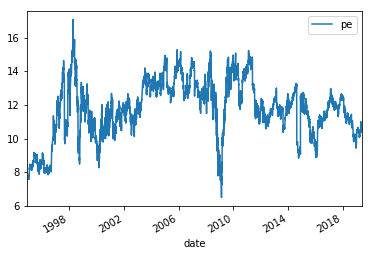

In [9]:
df.plot(x = 'date', y = 'pe')


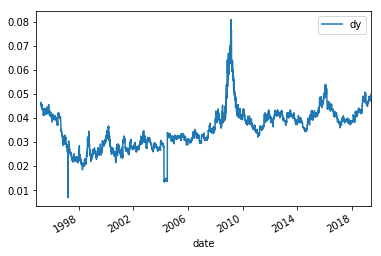

In [10]:
df.plot(x = 'date', y = 'dy')

In [20]:
def market_df(symbol):

    #tmx.db
        #tmx_earnings - uses '.', not split-adjusted
            #<symbol, date, eps>

    #yahoo.db
        #tsx_prices - uses '.'
            #<symbol, Date, Close>
        #splits - uses '-'
            #<symbol, date, total_adjustment>
        #divs - split-adjusted, uses '-''
            #<symbol, Date, Dividends>
        #yahoo_indicators - split-adjusted, uses '-'
            #<symbol, Date, eps, div_payout>
        #aav_prices - uses '-'
            #<symbol, Date, Close
            
    #advfn - no source data, contains company metatdata and currently where regression metrics are written to

    symbol_yahoo = symbol.replace('.','-') #'BNS'
    symbol_google = symbol.replace('-','.') #'BNS'

    tmx_sql = 'SELECT date, eps FROM tmx_earnings WHERE symbol = "{0}"'
    df_tmx = pd.read_sql(tmx_sql.format(symbol_google), tmx_conn, parse_dates = {'date' : '%Y-%m-%d'})
    df_tmx.columns = ['date', 'eps_raw']

    tsx_prices_sql = 'SELECT Date, Close FROM tsx_prices WHERE symbol = "{0}"'
    df_tsx_prices = pd.read_sql(tsx_prices_sql.format(symbol_google), yahoo_conn, parse_dates = {'Date' : '%Y-%m-%d'})
    df_tsx_prices.columns = ['date' , 'close']

    splits_sql = 'SELECT date, total_adjustment FROM splits WHERE symbol = "{0}"'
    df_splits = pd.read_sql(splits_sql.format(symbol_yahoo), yahoo_conn, parse_dates = {'date' : '%Y-%m-%d'})

    divs_sql = 'SELECT Date, Dividends FROM divs WHERE symbol = "{0}"'
    df_divs = pd.read_sql(divs_sql.format(symbol_yahoo), yahoo_conn, parse_dates = {'Date' : '%Y-%m-%d'})
    df_divs.columns = ['date', 'div_raw']
    
    divs = (df_divs.shape[0] != 0)          

    yahoo_indicators_sql = 'SELECT Date, eps, div_payout FROM yahoo_indicators WHERE symbol = "{0}"'
    df_yahoo = pd.read_sql(yahoo_indicators_sql.format(symbol_yahoo), yahoo_conn, parse_dates ={'Date' : '%Y-%m-%d'})
    df_yahoo.columns = ['date', 'eps', 'div']

    aav_sql = 'SELECT Date, Close FROM aav_prices WHERE symbol = "{0}"'
    df_aav = pd.read_sql(aav_sql.format(symbol_yahoo), yahoo_conn, parse_dates ={'Date' : '%Y-%m-%d'})
    df_aav.columns = ['date', 'close'] 

    df_price = pd.concat([df_tsx_prices[df_tsx_prices['close'].notnull()][['date', 'close']], df_aav[df_aav['close'].notnull()][['date','close']]])
    print('Before merge: ' + str(df_price.shape))
    df_price.drop_duplicates(subset ="date", inplace = True) 
    print('After merge: ' + str(df_price.shape))

    df_fix_tmx = df_tmx.join(df_splits.set_index('date'), on = 'date', how = 'outer', sort = True)
    #df_fix_tmx['total_adjustment'].fillna(method='ffill', inplace = True)
    df_fix_tmx['total_adjustment'].fillna(method='bfill', inplace = True)
    df_fix_tmx['total_adjustment'].fillna(1, inplace = True)
    df_fix_tmx['eps'] = 4.0 * df_fix_tmx['eps_raw']# / df_fix_tmx['total_adjustment']
    df_fix_tmx.dropna(inplace = True)

    #df_fix_tmx.plot(x = 'date', y = 'eps')

    df_fix_tmx.drop(['eps_raw', 'total_adjustment'], axis = 1, inplace = True)


    df_eps = pd.concat([df_fix_tmx, df_yahoo[df_yahoo['eps'].notnull()][['date', 'eps']]])
    df_eps = df_eps[df_eps['eps'] != 0]
    df_eps.drop_duplicates(subset ="date", inplace = True)
    df_eps.sort_values(by = 'date', inplace = True)

    if divs:
        df_div = df_divs.copy().join(df_splits.set_index('date'), on = 'date', how = 'outer', sort = True)

        df_div['total_adjustment'].fillna(method='bfill', inplace = True)
        df_div['total_adjustment'].fillna(1, inplace = True)

        df_div['div'] = df_div['div_raw'] * 4.0 / df_div['total_adjustment']

        df_div.dropna(inplace = True)

        df_div.drop(['div_raw', 'total_adjustment'], axis = 1, inplace = True)

        df_div = pd.concat([df_div, df_yahoo[['date', 'div']]])

    df_eps.drop_duplicates(subset ="date", inplace = True)
    
    if divs:
        df_div.sort_values(by = 'date', inplace = True)

    df = df_price.join(df_eps.set_index('date'), on = 'date', how = 'outer', sort = True)
    df['eps'].fillna(method = 'ffill', inplace = True)
    
    if divs:
        df = df.join(df_div.set_index('date'), on = 'date', how = 'outer', sort = True)
        df['div'].fillna(method = 'ffill', inplace = True)

        df['dy'] = df['div'] / df['close']

    df['pe'] = df['close'] / df['eps']

    return df[df['close'].notnull()], divs

In [48]:
df2, dv = market_df('REI-UN')


Before merge: (5952, 2)
After merge: (5853, 2)


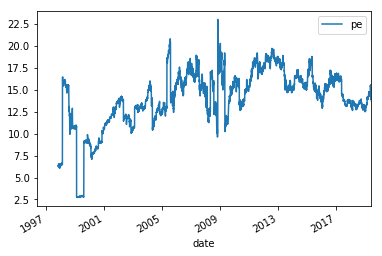

In [49]:
df2.plot(x = 'date', y = 'pe')

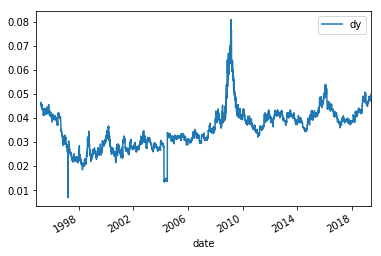

In [51]:
df.plot(x = 'date', y = 'dy')

In [52]:
dv

True